In [1]:
import torch
import os
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np

import utils
from utils import plot_2d, load_plot_2d, load_model_from_checkpoint, correlation_coefficients
from main_save_mcc import train_model, test_model
from lib.metrics import mean_corr_coef as mcc

In [2]:
# ROOT_DIR = (os.path.abspath(''))
MODEL_DIR = "pt_models"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RESULTS_DIR = "results"

## Reproduced results on synthetic dataset

## MCC and model loss

In [3]:
def plot_test_performances():
    """
    Plots the MCC and Deep Energy results of the base dataset for seeds 1 to 60.
    """
    with open(osp.join(RESULTS_DIR, 'eval_performances.txt')) as f:
        performances = list(map(eval, f.readline().split(',')[1:]))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    fig.tight_layout()

    ax1.plot(performances, '-.', color='gold', label=f'iFlow:{round(np.mean(performances), 4)}({round(np.std(performances), 4)})')
    ax1.legend()
    ax1.set_xlabel('Seed Number')
    ax1.set_ylabel('MCC')

    energy_values = np.load(os.path.join('results', 'energy_values.npy'))

    ax2.plot(energy_values, '-.', color='gold', label=f'iFlow:{round(np.mean(energy_values), 4)}')
    ax2.legend()
    ax2.set_xlabel('Seed Number')
    ax2.set_ylabel('Energy Value')
    plt.show()

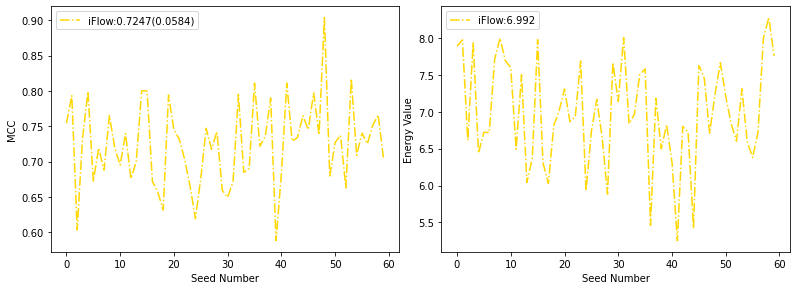

In [4]:
plot_test_performances()

## Visualization of 2D cases (seed 1 to 10)

In [3]:
# Arguments for the used 2D dataset is the following string: '1000_5_2_2_3_$seed_gauss_xtanh_u_f'
# For plotting, seed argument will automatically be replaced by the correct seed (1-10)

iFlow_file = osp.join('results','2D_mcc_scores/iFlow_1000_5_3.txt')
iVAE_file = 'iVAE_1000_5_3.txt'

seeds = range(1, 11)
data_args = "1000_5_2_2_3_$seed_gauss_xtanh_u_f"

load_plot_2d(seeds, data_args, iFlow_results_file=iFlow_file, iVAE_results_file=None)

iFlow mean = 0.6436, std = 0.0000
len iFlow array: 1
Dataset seed = 1


TypeError: 'NoneType' object is not subscriptable

In [29]:
# Manually test a checkpoint's MCC performance
CKPT_PATH = osp.join(MODEL_DIR, '1000_40_5_5_3_49_gauss_xtanh_u_f_iFlow_20/1_ckpt_10000.pth')

model = load_model_from_checkpoint(CKPT_PATH, device=device)

model.eval()
test_model(model, device=device)

checkpoint path: pt_models/1000_40_5_5_3_49_gauss_xtanh_u_f_iFlow_20/1_ckpt_10000.pth
Loading model iFlow
Loading data data/1/tcl_1000_40_5_5_3_49_gauss_xtanh_u.npz
x.shape == torch.Size([40000, 5])
s.shape == (40000, 5)
u.shape == torch.Size([40000, 40])
{'file': 'data/1/tcl_1000_40_5_5_3_49_gauss_xtanh_u.npz', 'path': 'data/1/tcl_1000_40_5_5_3_49_gauss_xtanh_u.npz', 'batch_size': 64, 'epochs': '20', 'device': device(type='cuda'), 'seed': 1, 'i_what': 'iFlow', 'max_iter': None, 'hidden_dim': 50, 'depth': 3, 'lr': 0.001, 'cuda': True, 'preload': True, 'anneal': False, 'log_freq': 25, 'flow_type': 'RQNSF_AG', 'num_bins': 8, 'nat_param_act': 'Softplus', 'gpu_id': '0', 'flow_length': 10, 'lr_drop_factor': 0.25, 'lr_patience': 10, 'nps': 1000, 'ns': 40, 'n': 40000, 'latent_dim': 5, 'data_dim': 5, 'aux_dim': 40}
x.shape == torch.Size([40000, 5])
s.shape == (40000, 5)
u.shape == torch.Size([40000, 40])


RuntimeError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 1.96 GiB total capacity; 655.26 MiB already allocated; 9.94 MiB free; 714.00 MiB reserved in total by PyTorch)

# Consistency across latent dimensions

Dataset seed =  48
MCC =  0.5192


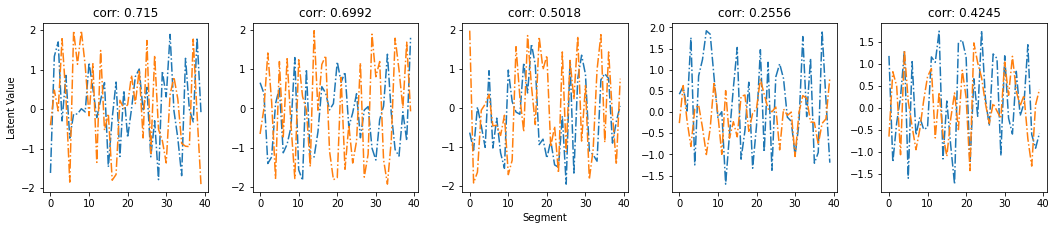

Dataset seed =  49
MCC =  0.4297


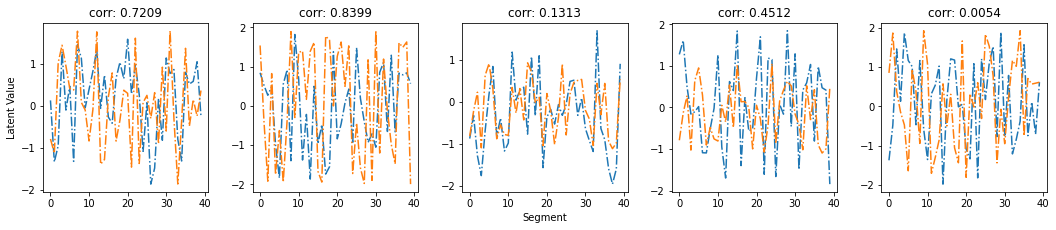

In [7]:
############# Have to grab z_est

# Only need iFlow z_est on local pc to test if this function works
# Should print both iFlow and iVAE results (if given)




def plot_5d_correlations(z_est_dataset_dir, show_iFlow=True, show_iVAE=True):
    data_arguments = z_est_dataset_dir.split('/')[-1]
    data_arguments = "_".join(data_arguments.split("_")[:-1]) # Remove last "_epochs" from string
    seed = data_arguments.split("_")[5]
    
    # load data 
    path_to_dataset = "data/1/tcl_"+ data_arguments[:-2] + ".npz"  # slice off "_f"
    with np.load(path_to_dataset) as data:
        x = data['x']
        u = data['u']
        s = data['s']
    # load predictions
    z_est_iFlow = None
    z_est_iVAE = None
    if show_iFlow:
        z_est_iFlow = np.load(osp.join(z_est_dataset_dir, "z_est_iFlow.npy"))
    if show_iVAE:
        z_est_iVAE = np.load(osp.join(z_est_dataset_dir, "z_est_iVAE.npy"))

    n, n_segments = u.shape
    points_per_seg = n // n_segments

    for model_idx, z_est in enumerate([z_est_iFlow, z_est_iVAE]):
        if z_est is not None:
            print('Dataset seed = ', seed)

            # Get correlation coefficients
            print('MCC = ', round(mcc(s, z_est), 4))
            corr_coefs = correlation_coefficients(s, z_est)

            mean_source = np.zeros((5, n_segments))
            mean_est = np.zeros((5, n_segments))

            for i in range(n_segments):
                for dim in range(5):
                    mean_source[dim][i] = np.mean(s[i*points_per_seg:(i+1)*points_per_seg, [dim]])
                    mean_est[dim][i] = np.mean(z_est[i*points_per_seg:(i+1)*points_per_seg, [dim]])

            # Standardize both signals (mean=0, std=1)
            mean_source = (mean_source - np.mean(mean_source, axis=0)) / np.std(mean_source, axis=0)
            mean_est = (mean_est - np.mean(mean_est, axis=0)) / np.std(mean_est, axis=0)

            fig, axes = plt.subplots(1, 5, figsize=(15, 3))
            fig.tight_layout()
            plt.gcf().subplots_adjust(bottom=0.15, left=0.05)

            for i in range(5):
                axes[i].plot(mean_source[i], linestyle='-.')
                axes[i].plot(mean_est[i], linestyle='-.')
                axes[i].set_title("corr: " + str(round(corr_coefs[i], 4)))

            axes[2].set_xlabel('Segment')
            axes[0].set_ylabel('Latent Value')
            plt.show()
            model_names = ['iFlow', 'iVAE']
            fig.savefig('results/mcc_across_dims/' + "_".join([model_names[model_idx], data_arguments]))

plot_5d_correlations(z_est_dataset_dir='z_est/1000_40_5_5_3_48_gauss_xtanh_u_f_20', show_iFlow=False)

plot_5d_correlations(z_est_dataset_dir='z_est/1000_40_5_5_3_49_gauss_xtanh_u_f_20', show_iFlow=False)

## Running the experiments

To train and evaluate an iFlow model on the standard dataset using a given seed, the following script can be run. 

% Geef uitleg over arguments zoals in  https://github.com/uva-fact-ai-course/uva-fact-ai-course/blob/master/DL-prototypes/results.ipynb

In [ ]:
!python main.py \
        -x 1000_40_5_5_3_1_gauss_xtanh_u_f \
        -i iFlow \
        -ft RQNSF_AG \
        -npa Softplus \
        -fl 10 \
        -lr_df 0.25 \
        -lr_pn 10 \
        -b 64 \
        -e 20 \
        -l 1e-3 \
        -s 1 \
        -u 0 \
        -c

### Training model for visualization of 2D latent space

In [11]:
seeds = [69]

# $seedvar will be overwritten using previously defined seed 
data_args = '1000_5_2_2_3_$seedvar_gauss_xtanh_u_f'
epochs = 3
batch_size = 64
i_what = 'iFlow' # 'iFlow' or 'iVAE'

for seed in seeds:
    temp_args = "_".join(["_".join(data_args.split("_")[:5]), str(seed), "_".join(data_args.split("_")[6:])])
    # Use -mcc or --save_mcc argument to log (append) performance to .txt file
    !python main_save_mcc.py --save_mcc --data-args=$temp_args -e=$epochs --batch-size=$batch_size --i-what=iFlow --cuda --flow_type=RQNSF_AG --nat_param_act=Softplus --preload-gpu

#     CKPT_PATH = osp.join(RESULTS_DIR, "_".join([temp_args, i_what, epochs]), /_ckpt_final.pth')

Namespace(anneal=False, batch_size=64, cuda=True, data_args='1000_5_2_2_3_69_gauss_xtanh_u_f', depth=3, epochs=3, file=None, flow_length=10, flow_type='RQNSF_AG', gpu_id='0', hidden_dim=50, i_what='iFlow', latent_dim=None, log_freq=25, lr=0.001, lr_drop_factor=0.25, lr_patience=10, max_iter=None, nat_param_act='Softplus', no_log=False, num_bins=8, preload=True, save_mcc=True, seed=1)
training on GeForce GTX 950M
data loaded on cuda
{'file': 'data/1/tcl_1000_5_2_2_3_69_gauss_xtanh_u.npz', 'data_args': '1000_5_2_2_3_69_gauss_xtanh_u_f', 'latent_dim': 2, 'batch_size': 64, 'epochs': 3, 'max_iter': None, 'hidden_dim': 50, 'depth': 3, 'lr': 0.001, 'seed': 1, 'cuda': True, 'preload': True, 'anneal': False, 'no_log': False, 'log_freq': 25, 'i_what': 'iFlow', 'flow_type': 'RQNSF_AG', 'num_bins': 8, 'nat_param_act': 'Softplus', 'gpu_id': '0', 'flow_length': 10, 'lr_drop_factor': 0.25, 'lr_patience': 10, 'save_mcc': True, 'device': device(type='cuda'), 'path': 'data/1/tcl_1000_5_2_2_3_69_gauss_xt

In [35]:
seeds = [69]

iFlow_file = 
iVAE_file = 
load_plot_2d(seeds, data_args, iFlow_results_file=iFlow_file, iVAE_results_file=iVAE_file)